In [ ]:
'''
this got stuck with what seems like GPU memory error

InternalError: Failed copying input tensor from 
/job:localhost/replica:0/task:0/device:CPU:0 to 
/job:localhost/replica:0/task:0/device:GPU:0 in 
order to run _EagerConst: Dst tensor is not initialized.

'''

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

In [ ]:

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

train_images = []
train_masks = []

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk'

rgb_images = os.listdir(rgb_path)

random.shuffle(rgb_images)

for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        train_images.append(img/255)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        train_masks.append(msk/255)
        
train_images = np.array(train_images)
X = tf.cast(train_images, tf.float32)
del(train_images)

train_masks = np.array(train_masks)
Y = tf.cast(train_masks, tf.float32)
del(train_masks)

x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

del(X)
del(Y)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)




In [ ]:
y_train[0]

In [ ]:
NAME = "UNET_640_480-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
#model.summary()

In [ ]:
# run without GPU
history = model.fit(x_train,y_train,batch_size=16,epochs=1,verbose=1,validation_data=(x_val,y_val),callbacks=[tensorboard])

In [ ]:
print(x_train.shape,' vs.',y_train.shape)

In [ ]:
# run with GPU
history = model.fit(x_train,y_train,batch_size=4,epochs=1,verbose=1,validation_data=(x_val,y_val),callbacks=[tensorboard])

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np

input_shape = (SIZE_Y,SIZE_X,3)
#print(model.summary())

def get_mem_usg(batch_size,model):
    features_mem = 0
    float_bytes = 4.0
    for layer in model.layers:
        out_shape = layer.output_shape
        if type(out_shape) is list:
            out_shape= out_shape[0]
        else:
            out_shape = [out_shape[1],out_shape[2],out_shape[3]]
        single_layer_mem = 1
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *=s
        single_layer_mem_float = single_layer_mem * float_bytes
        single_layer_mem_MB = single_layer_mem_float /(1024**2)
        print("memory for", out_shape," layer in MB is: ",single_layer_mem_MB)
        features_mem += single_layer_mem_MB
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB =((trainable_wts+non_trainable_wts) * float_bytes)/(1024**2)
    print("_____________________________________")
    print("Memory for features in MB is: ", features_mem * batch_size)
    print("Memory for parameters in MB is: %.2f" %parameter_mem_MB)
    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB
    total_memory_GB = total_memory_MB/1024
    return total_memory_GB

mem_for_my_model = get_mem_usg(16,model)
print("_____________________________________")
print("Min memory for my model in GB is: %.2f" %mem_for_my_model)

In [ ]:
model.

In [ ]:
# code for estimating memory requirements of the model

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np


input_image_shape = (SIZE_X,SIZE_Y,3)

print(model.summary())


def get_model_memory_usage(batch_size, model):
    
    features_mem = 0 # Initialize memory for features. 
    float_bytes = 4.0 #Multiplication factor as all values we store would be float32.
    
    for layer in model.layers:

        out_shape = layer.output_shape
        
        if type(out_shape) is list:   #e.g. input layer which is a list
            out_shape = out_shape[0]
        else:
            out_shape = [out_shape[1], out_shape[2], out_shape[3]]
            
        #Multiply all shapes to get the total number per layer.    
        single_layer_mem = 1 
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        
        single_layer_mem_float = single_layer_mem * float_bytes #Multiply by 4 bytes (float)
        single_layer_mem_MB = single_layer_mem_float/(1024**2)  #Convert to MB
        
        print("Memory for", out_shape, " layer in MB is:", single_layer_mem_MB)
        features_mem += single_layer_mem_MB  #Add to total feature memory count

# Calculate Parameter memory
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB = ((trainable_wts + non_trainable_wts) * float_bytes)/(1024**2)
    print("_________________________________________")
    print("Memory for features in MB is:", features_mem*batch_size)
    print("Memory for parameters in MB is: %.2f" %parameter_mem_MB)

    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB  #Same number of parameters. independent of batch size

    total_memory_GB = total_memory_MB/1024
    
    return total_memory_GB

#####################################################################

mem_for_my_model = get_model_memory_usage(16, model)

print("_________________________________________")
print("Minimum memory required to work with this model is: %.2f" %mem_for_my_model, "GB")

In [ ]:
plot_model(model)

In [ ]:

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk'

rgb_images = os.listdir(rgb_path)

random.shuffle(rgb_images)

for file in rgb_images[0:1]:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        print('rgb shape',img.shape)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        print('mask shape',msk.shape)
        

In [ ]:
img_count

In [ ]:
# start new model training full code
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 4_000

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk'

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_640_480-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
#model.summary()

history = model.fit(x_train,y_train,batch_size=16,epochs=10,verbose=1,validation_data=(x_val,y_val),callbacks=[tensorboard])

In [ ]:
model.save('model/{}'.format(NAME),save_format='tf')

In [ ]:
#test on real Tesla video
m3_video = cv2.VideoCapture('C:/Users/Vadim/Videos/Captures/2023-03-14_17-06-47/2023-03-14_16-58-30-front.mp4')

while(m3_video.isOpened()):
    # Capture frame-by-frame
    ret, frame = m3_video.read()
    if ret == True:
        # Display the resulting frameabs
        frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
        frame = cv2.flip(frame, 1)
        img = np.float32(frame /255)
        input_for_model = img[ :, :, None] 
        input_for_model = np.expand_dims(img, axis=0)
        mask = model(input_for_model,training=False)
        final_mask = (np.squeeze(mask[0].numpy()) * 255)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
        cv2.imshow('predicted mask',result)
        
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
        # Break the loop
    else: 
        break
# When everything done, release the video capture object
m3_video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
# continue model training full code
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
from tensorflow.keras.models import load_model
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 10_000

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk'

rgb_images = os.listdir(rgb_path)
random.seed(42)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_640_480-1679375664"
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

model = load_model("model/{}".format(NAME),compile=False)
#model.compile()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
#model = sm.Unet(BACKBONE, encoder_weights='imagenet')
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
#model.summary()

history = model.fit(x_train,y_train,batch_size=8,epochs=10,verbose=1,validation_data=(x_val,y_val),callbacks=[tensorboard])
model.save('model/{}'.format(NAME+"_upd"),save_format='tf')

In [ ]:
#test on in train/val images from simulator
# this showed that training for driveable surface is more difficult than for lanes

import os
import time
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

SIZE_X = 640
SIZE_Y = 480
NAME = "UNET_640_480-1679375664"

model = load_model("model/{}".format(NAME),compile=False)

rgb_path = 'c:/SelfDrive/out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    frame = cv2.flip(frame, 1)
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
    cv2.imshow('predicted mask',result)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

In [5]:
# start new model training full code - THIS CREATED ALL IN MASK _ FAILURE
# Lane marking only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 2_000

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk_ln'

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_LANES_640_480-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss=sm.losses.BinaryFocalLoss(),metrics=['mse'])
#model.summary()

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

history = model.fit(x_train,y_train,batch_size=16,epochs=10,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

Epoch 1/10
100/100 [==============================] - 3510s 35s/step - loss: 0.0051 - mse: 0.0202 - val_loss: 0.0183 - val_mse: 0.0178
Epoch 2/10
100/100 [==============================] - 3483s 35s/step - loss: 0.0024 - mse: 0.0103 - val_loss: 0.0097 - val_mse: 0.0202
Epoch 3/10
100/100 [==============================] - 3493s 35s/step - loss: 0.0020 - mse: 0.0084 - val_loss: 0.0135 - val_mse: 0.0171
Epoch 4/10
100/100 [==============================] - 3481s 35s/step - loss: 0.0020 - mse: 0.0079 - val_loss: 0.0114 - val_mse: 0.0172
Epoch 5/10
100/100 [==============================] - 3480s 35s/step - loss: 0.0019 - mse: 0.0074 - val_loss: 0.0151 - val_mse: 0.0168
Epoch 6/10
100/100 [==============================] - 3476s 35s/step - loss: 0.0022 - mse: 0.0084 - val_loss: 0.0082 - val_mse: 0.0283
Epoch 7/10
100/100 [==============================] - 3485s 35s/step - loss: 0.0018 - mse: 0.0070 - val_loss: 0.0079 - val_mse: 0.0160
Epoch 8/10
100/100 [==============================] - 3

INFO:tensorflow:Assets written to: model/UNET_LANES_640_480-1679951659\assets


INFO:tensorflow:Assets written to: model/UNET_LANES_640_480-1679951659\assets


In [ ]:
model.save('model/{}'.format(NAME),save_format='tf')

In [ ]:
history = model.fit(x_train,y_train,batch_size=16,epochs=30,verbose=1,validation_data=(x_val,y_val),callbacks=[model_checkpoint_callback])

In [7]:
# use the model just trained



from tensorflow.keras.models import load_model

SIZE_X = 640
SIZE_Y = 480
NAME = "UNET_LANES_640_480-1679951659"

model = load_model("model/{}".format(NAME),compile=False)


rgb_path = 'c:/SelfDrive/out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    frame = cv2.flip(frame, 1)
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
    cv2.imshow('predicted mask',result)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

In [1]:
# ALL masks attempt as a regression
# added 3 colours for second run
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import cv2
import random
import time
import numpy as np


BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 2_000

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/sem'

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_ALL_REGR_640_480-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())
#model.summary()

history = model.fit(x_train,y_train,batch_size=32,epochs=2,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

Segmentation Models: using `keras` framework.
Epoch 1/2
50/50 [==============================] - 3520s 70s/step - loss: 0.0318 - val_loss: 0.1144
Epoch 2/2
50/50 [==============================] - 3492s 70s/step - loss: 0.0289 - val_loss: 0.0390


INFO:tensorflow:Assets written to: model/UNET_ALL_REGR_640_480-1680058544\assets


INFO:tensorflow:Assets written to: model/UNET_ALL_REGR_640_480-1680058544\assets


In [7]:
# apply model on random images

import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import cv2
import random
import os
import numpy as np

SIZE_X = 640
SIZE_Y = 480

#first
NAME = "UNET_640_480-1679375664"
#lanes
#NAME = "UNET_LANES_640_480-1679951659"
#latest
#NAME = "UNET_LANES_640_480-1679951659"
model = load_model("model/{}".format(NAME),compile=False)

rgb_path = 'c:/SelfDrive/out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
   
    cv2.imshow('initial image',frame)
    cv2.waitKey(2000)
    cv2.imshow('predicted mask',final_mask)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

In [8]:
# Investigation
### The final issue is - the model only gives one dimension rather than 3
# checked original working model output - also give non-integer

(None, None, None, 1)

In [14]:
# trying to measure how imbalanced lane masks are:
SIZE_X = 640
SIZE_Y = 480
msk_path = 'c:/SelfDrive/out_sem/msk_ln'
msk_images = os.listdir(msk_path)
img_count = len(msk_images)
x =  np.zeros(shape=(img_count,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
for file in msk_images:
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        x[i] = msk/255
        i += 1
        


In [15]:
np.average(x)

0.01715

In [18]:
avg_mask = np.average(x,axis=0)

In [19]:
# what does average mask look like - which area of the screen to focus on in a loss

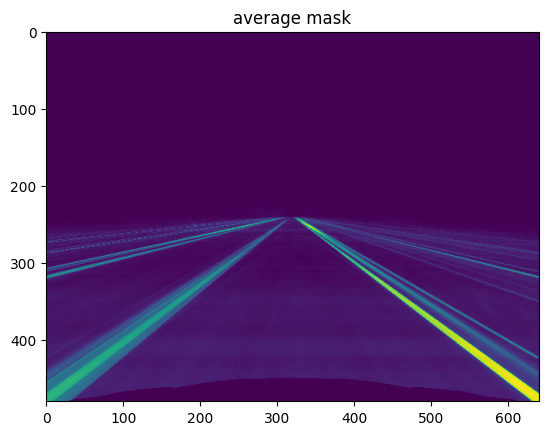

In [21]:
from matplotlib import pyplot as plt #to show images in this notebook
plt.imshow(avg_mask)
plt.title('average mask')
plt.show()

In [22]:
avg_mask

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.2107, 0.2083, 0.2085, ..., 0.316 , 0.3162, 0.3152],
       [0.2076, 0.2067, 0.2069, ..., 0.317 , 0.317 , 0.3164],
       [0.2068, 0.2068, 0.2054, ..., 0.3176, 0.318 , 0.318 ]],
      dtype=float16)

In [ ]:
# code from Shima
def class_weighted_cross_entropy_loss(y_true,y_pred,class_weights)
    cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true,y_pred,from_logits=False)
    class_weights = tf.reshape(class_weights,[1,1,1,-1])
    weighterd_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * class_weights)
    return weighterd_cross_entropy_loss

In [25]:
class_weights = np.array([0.98,0.02])

In [27]:
test = tf.reshape(class_weights,[1,1,1,-1])

In [ ]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', np.unique(x),x)
print(weights)

In [16]:
# try weighted model
# Lane marking only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.utils import class_weight

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 1_000

rgb_path = 'c:/SelfDrive/out_sem/rgb'
msk_path = 'c:/SelfDrive/out_sem/msk_ln'


def class_weighted_cross_entropy_loss(y_true,y_pred):
    class_weights = np.array([0.98,0.02])
    cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true,y_pred,from_logits=False)
    class_weights = tf.cast(tf.reshape(class_weights,[1,-1]), tf.float32)
    tf.cast(cross_entropy_loss, tf.float32)
    weighterd_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * class_weights)
    return weighterd_cross_entropy_loss


rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_LANES_WCE_LOSS-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss=class_weighted_cross_entropy_loss,metrics=['mse'])
#model.summary()


history = model.fit(x_train,y_train,batch_size=16,epochs=1,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

ValueError: in user code:

    File "C:\Users\Vadim\.conda\envs\tf2\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Vadim\AppData\Local\Temp\ipykernel_17868\2685809386.py", line 34, in class_weighted_cross_entropy_loss  *
        weighterd_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * class_weights)

    ValueError: Dimensions must be equal, but are 480 and 2 for '{{node class_weighted_cross_entropy_loss/mul_2}} = Mul[T=DT_FLOAT](class_weighted_cross_entropy_loss/Mean, class_weighted_cross_entropy_loss/Cast)' with input shapes: [16,480], [1,2].


array([0., 1.], dtype=float16)